# Group-11 Major Project - RULE-BASED HINDI TO INDIAN SIGN LANGUAGE TRANSLATION SYSTEM
### Done by
1. Abhishek Srivastava (2100520100003)
2. Govind Singh Tomar (2100520100029)
3. Prashant Kumar Singh (2100520100049)

## Setup and Library Imports

In [2]:
# import statements
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import networkx as nx
import stanza
import nlp
import pandas as pd
import ast
import re
import pyiwn
from nltk.corpus import wordnet as wn
import nltk
from IPython.display import Video, display
import functools

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Input the sentence

In [3]:
hindi_sentence = input('Enter the hindi sentence : ')

# POS Tagging and Dependency Parsing - STANZA

In [4]:
# Initialize the Hindi NLP pipeline with required processors
nlp_pipeline = stanza.Pipeline('hi', processors='tokenize,lemma,pos,depparse')
document = nlp_pipeline(hindi_sentence)
print(document)

2025-05-11 17:13:13 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-05-11:17:13:13,212 INFO     [core.py:207] Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-05-11 17:13:13 INFO: Downloaded file to C:\Users\user\stanza_resources\resources.json
2025-05-11:17:13:13,407 INFO     [common.py:161] Downloaded file to C:\Users\user\stanza_resources\resources.json
2025-05-11 17:13:14 INFO: Loading these models for language: hi (Hindi):
| Processor | Package       |
-----------------------------
| tokenize  | hdtb          |
| pos       | hdtb_charlm   |
| lemma     | hdtb_nocharlm |
| depparse  | hdtb_charlm   |

2025-05-11:17:13:14,643 INFO     [core.py:271] Loading these models for language: hi (Hindi)

[
  [
    {
      "id": 1,
      "text": "क्या",
      "lemma": "क्या",
      "upos": "PRON",
      "xpos": "WQ",
      "feats": "PronType=Int",
      "head": 4,
      "deprel": "obl",
      "start_char": 0,
      "end_char": 4
    },
    {
      "id": 2,
      "text": "यहाँ",
      "lemma": "यहाँ",
      "upos": "PRON",
      "xpos": "PRP",
      "feats": "Case=Nom|PronType=Prs",
      "head": 4,
      "deprel": "obl",
      "start_char": 5,
      "end_char": 9
    },
    {
      "id": 3,
      "text": "बारिश",
      "lemma": "बारिश",
      "upos": "NOUN",
      "xpos": "NN",
      "feats": "Case=Nom|Gender=Fem|Number=Sing|Person=3",
      "head": 4,
      "deprel": "compound",
      "start_char": 10,
      "end_char": 15
    },
    {
      "id": 4,
      "text": "हो",
      "lemma": "होना",
      "upos": "VERB",
      "xpos": "VM",
      "feats": "Gender=Fem|Number=Sing|Person=3|Voice=Act",
      "head": 0,
      "deprel": "root",
      "start_char": 16,
      "end_char": 18
    },
 

In [5]:
# Extract relevant fields from each token in the first sentence
token_data = [
    (token['text'], token['upos'], token['xpos'], token['head'], token['deprel'])
    for token in document.to_dict()[0]
]

# Create a DataFrame to display token information
df_tokens = pd.DataFrame(token_data, columns=[
    'Text word', 'Universal POS tag', 'Treebank-specific POS (XPOS) tag', 'Parent index', 'Dependency relation'
])
df_tokens.index += 1
display(df_tokens)

# Display the root (highest ranked) word
print("\nThe root (highest ranked) word is:")
print(df_tokens.loc[df_tokens['Parent index'] == 0]['Text word'].iloc[0])

,Text word,Universal POS tag,Treebank-specific POS (XPOS) tag,Parent index,Dependency relation
1,क्या,PRON,WQ,4,obl
2,यहाँ,PRON,PRP,4,obl
3,बारिश,NOUN,NN,4,compound
4,हो,VERB,VM,0,root
5,रही,AUX,VAUX,4,aux
6,है,AUX,VAUX,4,aux:pass
7,?,PUNCT,SYM,4,punct



The root (highest ranked) word is:
हो


# Visualize Dependence Tree

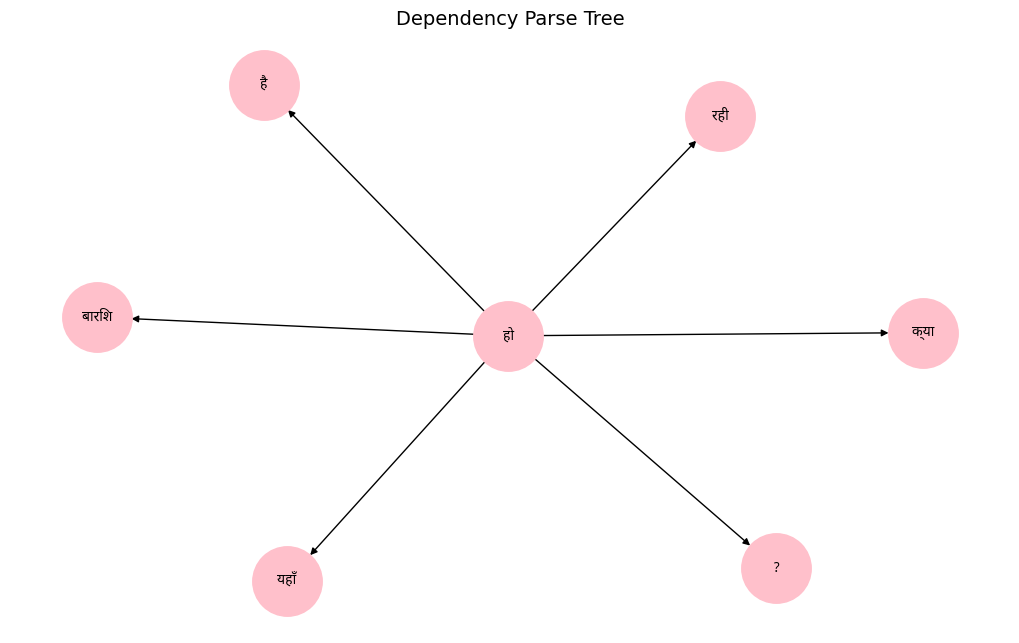

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.font_manager as fm

# Load Hindi font
hindi_font_path = r"utility\NotoSansDevanagari.ttf"  # Ensure this is a valid path on your system
hindi_font = fm.FontProperties(fname=hindi_font_path)

# Create a directed graph and map nodes to token text
dependency_graph = nx.DiGraph()
node_labels = {}

for idx, row in df_tokens.iterrows():
    node_labels[idx] = row["Text word"]
    if row["Parent index"] != 0:  # Skip the root as it has no parent
        dependency_graph.add_edge(row["Parent index"], idx)

# Use spring layout instead of graphviz_layout
graph_layout = nx.spring_layout(dependency_graph, seed=42)  # You can also try nx.shell_layout or nx.kamada_kawai_layout

# Draw the dependency tree
plt.figure(figsize=(10, 6))
nx.draw(dependency_graph, pos=graph_layout, with_labels=True, labels=node_labels,
        node_color="pink", edge_color="black", node_size=2500, font_size=12, arrows=True)

# Apply Devanagari font to all labels
for text in plt.gca().texts:
    text.set_fontproperties(hindi_font)

plt.title("Dependency Parse Tree", fontsize=14)
plt.show()


# Extract Tags for Each Word

In [7]:
word_tags = []
for sentence in document.sentences:
    for word in sentence.words:
        word_info = {
            "text": word.text,
            "xpos": word.xpos,
            "id": word.id,
            "lemma": word.lemma,
            "deprel": word.deprel,
            "head": word.head
        }
        word_tags.append(word_info)
print(word_tags)

[{'text': 'क्या', 'xpos': 'WQ', 'id': 1, 'lemma': 'क्या', 'deprel': 'obl', 'head': 4}, {'text': 'यहाँ', 'xpos': 'PRP', 'id': 2, 'lemma': 'यहाँ', 'deprel': 'obl', 'head': 4}, {'text': 'बारिश', 'xpos': 'NN', 'id': 3, 'lemma': 'बारिश', 'deprel': 'compound', 'head': 4}, {'text': 'हो', 'xpos': 'VM', 'id': 4, 'lemma': 'होना', 'deprel': 'root', 'head': 0}, {'text': 'रही', 'xpos': 'VAUX', 'id': 5, 'lemma': 'रहना', 'deprel': 'aux', 'head': 4}, {'text': 'है', 'xpos': 'VAUX', 'id': 6, 'lemma': 'है', 'deprel': 'aux:pass', 'head': 4}, {'text': '?', 'xpos': 'SYM', 'id': 7, 'lemma': '?', 'deprel': 'punct', 'head': 4}]


## **Remove Unwanted Tags**
 -------------------------------------------------------------------
### Define unwanted XPOS tags:
- VAUX (Verb Auxiliary)
- CC (Coordinating Conjunction)
- SYM (Symbol)
- PSP (Postposition)

In [8]:
unwanted_tags = ['VAUX', 'CC', 'SYM', 'PSP']
cleaned_word_tags = {}
for word_info in word_tags:
    if word_info['xpos'] not in unwanted_tags:
        cleaned_word_tags[word_info['id']] = word_info

for key, value in cleaned_word_tags.items():
    print(key, value)

1 {'text': 'क्या', 'xpos': 'WQ', 'id': 1, 'lemma': 'क्या', 'deprel': 'obl', 'head': 4}
2 {'text': 'यहाँ', 'xpos': 'PRP', 'id': 2, 'lemma': 'यहाँ', 'deprel': 'obl', 'head': 4}
3 {'text': 'बारिश', 'xpos': 'NN', 'id': 3, 'lemma': 'बारिश', 'deprel': 'compound', 'head': 4}
4 {'text': 'हो', 'xpos': 'VM', 'id': 4, 'lemma': 'होना', 'deprel': 'root', 'head': 0}


# Grammer Rules based Reordering

1. Noun Verb

2. Assumption:  Subject always comes before object
    राम ने श्याम को कहा
    Subject Object Verb

3. Verb Auxiliary Verb

4. Verb Adverb

5. Noun Adjective

-----------------------------------------------------
#### Subjective S_Adjective Object O_Adjective Verb Adverb
-----------------------------------------------------
#### Arrange in Order : Pronoun Subjective S_Adjective Object O_Adjective -> Noun Adjective Verb Adverb

In [9]:
# Reorders word_dict by moving the entry with key row1 to the position of row2.
# If row1 and row2 are the same, the original dictionary is returned.

def change_dict_order(word_dict, row1, row2):
    if row1 == row2:
        return word_dict
    items = list(word_dict.items())
    index1 = None
    index2 = None
    for i, (key, _) in enumerate(items):
        if key == row1:
            index1 = i
        elif key == row2:
            index2 = i
    entry = items.pop(index1)
    items.insert(index2, entry)
    return {k: v for k, v in items}

# Format Subject and Object

In [10]:
# Copy cleaned_word_tags for ordering specific to sign language
word_sign_order = cleaned_word_tags.copy()

# Identify subject and object for reordering
subject_id = None
object_id = None
counter = 0
for key, value in cleaned_word_tags.items():
    if value['deprel'] in ['obj', 'obl']:
        object_id = key
    elif value['deprel'] == 'nsubj':
        subject_id = key
    counter += 1

# If subject comes after object, swap their order
if subject_id is not None and object_id is not None and subject_id > object_id:
    word_sign_order = change_dict_order(word_sign_order, object_id, subject_id)

for key, value in word_sign_order.items():
    print(key, value)

1 {'text': 'क्या', 'xpos': 'WQ', 'id': 1, 'lemma': 'क्या', 'deprel': 'obl', 'head': 4}
2 {'text': 'यहाँ', 'xpos': 'PRP', 'id': 2, 'lemma': 'यहाँ', 'deprel': 'obl', 'head': 4}
3 {'text': 'बारिश', 'xpos': 'NN', 'id': 3, 'lemma': 'बारिश', 'deprel': 'compound', 'head': 4}
4 {'text': 'हो', 'xpos': 'VM', 'id': 4, 'lemma': 'होना', 'deprel': 'root', 'head': 0}


# Handling Adjective and Adverb

In [11]:
for key, value in cleaned_word_tags.items():
    if value['xpos'] == 'JJ':  # Adjective
        # If the adjective's head is a noun, adjust its position accordingly
        if value['head'] != 0 and cleaned_word_tags[value['head']]['xpos'] == 'NN':
            word_sign_order = change_dict_order(
                word_sign_order, key, value['head'])
    elif value['xpos'] == 'RB':  # Adverb
        if value['head'] != 0 and cleaned_word_tags[value['head']]['xpos'] in ['VM', 'VAUX']:
            word_sign_order = change_dict_order(
                word_sign_order, key, value['head'])
print(word_sign_order)

{1: {'text': 'क्या', 'xpos': 'WQ', 'id': 1, 'lemma': 'क्या', 'deprel': 'obl', 'head': 4}, 2: {'text': 'यहाँ', 'xpos': 'PRP', 'id': 2, 'lemma': 'यहाँ', 'deprel': 'obl', 'head': 4}, 3: {'text': 'बारिश', 'xpos': 'NN', 'id': 3, 'lemma': 'बारिश', 'deprel': 'compound', 'head': 4}, 4: {'text': 'हो', 'xpos': 'VM', 'id': 4, 'lemma': 'होना', 'deprel': 'root', 'head': 0}}


# Handling Negative Sentences

In [12]:
for key, value in word_sign_order.items():
    if value['xpos'] == 'NEG':
        last_key = list(word_sign_order.keys())[-1]
        word_sign_order = change_dict_order(word_sign_order, key, last_key)

# Handling Interrogative Sentences

In [13]:
for key, value in word_sign_order.items():
    if value['xpos'] == 'WQ':
        last_key = list(word_sign_order.keys())[-1]
        word_sign_order = change_dict_order(word_sign_order, key, last_key)

# StopWord Removal - For Sentences like मैं खुश हूं।
#### हूं - comes out to be VM

In [14]:
# Read stopwords from file
with open('./utility/final_stopwords.txt', 'r',encoding='utf8') as file:
    # Read the entire contents of the file
    stopword_list = file.readlines()
stopword_list = [word.strip() for word in stopword_list]

In [15]:
# StopWord Removal
stopword_removed_list = {}
for key,value in word_sign_order.items():
    #print(value['text'] in stopword_list)
    if value['text'] not in stopword_list:
        stopword_removed_list[key] = value

In [16]:
for key,value in stopword_removed_list.items():
    print(key,value)

2 {'text': 'यहाँ', 'xpos': 'PRP', 'id': 2, 'lemma': 'यहाँ', 'deprel': 'obl', 'head': 4}
3 {'text': 'बारिश', 'xpos': 'NN', 'id': 3, 'lemma': 'बारिश', 'deprel': 'compound', 'head': 4}
1 {'text': 'क्या', 'xpos': 'WQ', 'id': 1, 'lemma': 'क्या', 'deprel': 'obl', 'head': 4}


# Mapping xpos to POS Tag

In [17]:
# Mapping xpos to POS tags
xpos_to_pos = {
    'NNP': 'pnoun',
    'VM': 'verb',
    'VAUX': 'verb',
    'JJ': 'adjective',
    'RB': 'adverb',
    'PRP' : 'pronoun',
    'NEG' : 'negative',
    'NN' : 'noun',
    'RDP' : 'adverb',
    'QF': 'adjective',            # 'अधिक'\
    'WQ': 'wh_adverb',
    'NST': 'noun_locative',
    'DEM': 'noun_refer_specific',
    'INTF': 'intensifier',
    # Add more mappings as needed
}

In [18]:
# Extract Words from Parser and corresponding tag
sign_words_list = []
for key,value in stopword_removed_list.items():
    if value['xpos'] in xpos_to_pos:
        sign_words_list.append((value['text'], xpos_to_pos[value['xpos']]))
    else:
        sign_words_list.append((value['text'], 'extra'))
print(sign_words_list)

[('यहाँ', 'pronoun'), ('बारिश', 'noun'), ('क्या', 'wh_adverb')]


# READ ISL Dictionary

In [19]:
# READ ISL Dictionary
# Open the file in read mode
with open('./utility/isl_dict.txt', 'r',encoding='utf8') as file:
    # Read the entire contents of the file
    isl_dict = ast.literal_eval(file.read())

In [20]:
## Use Case : Why_(Sign_2) should be why
# Remove content within parentheses and strip whitespace for keys containing "_(*)"
isl_dict = {re.sub(r'_\(.*\)', '', key).strip().lower(): value for key, value in isl_dict.items()}

In [21]:
# Create a new dictionary with lowercase keys
isl_dict = {key.lower(): value for key, value in isl_dict.items()}
isl_dict['school'] = 'स्कूल'

In [22]:
# # Google Translator
# from googletrans import Translator
# # Create a Translator object
# translator = Translator()

# Google Translator using deep-translator
from deep_translator import GoogleTranslator

# Create a Translator object and translate text
translator = GoogleTranslator(source='auto', target='en')

# Synonym Substitution

In [23]:
# Synonym Substitution
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')  # For WordNet lemmatizer

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Initialize IndoWordNet
iwn = pyiwn.IndoWordNet()

# Example: English lemmatization
print("Lemmatized 'running':", lemmatizer.lemmatize('running'))  # Output: run

# Hindi synonym using IndoWordNet
print("E.g. आम्र:", end=" ")
print(iwn.synsets('आम्र'))  # Prints synsets of 'आम्र' (mango)

# Special video dictionary (unchanged)
special_videos = {
    'i': 'I',
    'who': '/content/drive/MyDrive/Major Project - Final Year/ISL Dictionary/W/Who_Whom.mp4',
    'whom': '/content/drive/MyDrive/Major Project - Final Year/ISL Dictionary/W/Who_Whom.mp4'
}

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
2025-05-11:17:14:41,435 INFO     [iwn.py:43] Loading hindi language synsets...


Lemmatized 'running': running
E.g. आम्र: [Synset('आम.noun.3462')]


In [26]:

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

synonym_substituted_list = []
temp_list = [('आकलन', 'noun')]
for word, pos_tag in sign_words_list:

    # Translate the Hindi sentence to English
    english_word = translator.translate(word, src='hi', dest='en').lower()
    english_word_lemmatized = lemmatizer.lemmatize(english_word)
    
    if english_word_lemmatized in list(special_videos.keys()):
        synonym_substituted_list.append((word, pos_tag, special_videos[english_word_lemmatized]))
        continue

    if pos_tag == 'pnoun':
        synonym_substituted_list.append((word, pos_tag, english_word))
        continue

    # Case 1 : Check hindi word in isl_dict
    if word in list(isl_dict.values()):
        synonym_substituted_list.append((word, pos_tag, english_word))
        continue

    all_hindi_synsets = []
    # Case 2 : Check synonym of hindi_word in isl_dict
    try:
        all_hindi_synsets = iwn.synsets(word)
    except Exception as e:
        pass

    flag = False
    for synset in all_hindi_synsets:
        if synset._head_word in list(isl_dict.values()):
            corresponding_keys = [key for key, value in isl_dict.items() if value == synset._head_word]
            synonym_substituted_list.append((word, pos_tag, corresponding_keys[0]))
            flag = True
            break
    if flag:
        continue

    # Case 3 : Check english word in isl_dict
    if english_word in list(isl_dict.keys()):
        synonym_substituted_list.append((word, pos_tag, english_word))
        continue

    # Case 4 : Check lemmatized english word in isl_dict
    if english_word_lemmatized in list(isl_dict.keys()):
        synonym_substituted_list.append((word, pos_tag, english_word_lemmatized))
        continue

    # Case 5 : Check syno of english word in isl_dict
    all_english_synsets = wn.synonyms(english_word)
    all_english_synsets_flatten = []
    for row in all_english_synsets:
        all_english_synsets_flatten.extend(row)

    flag = False
    for synset in all_english_synsets_flatten:
        if synset.lower() in list(isl_dict.keys()):
            flag = True
            synonym_substituted_list.append((word, pos_tag, synset.lower()))
            break
    if flag:
        continue

    # Case 6  : Nothing Words Go for Finger Spelling
    synonym_substituted_list.append((word, pos_tag, '#'))

print(synonym_substituted_list)


[('यहाँ', 'pronoun', 'here'), ('बारिश', 'noun', 'rain'), ('क्या', 'wh_adverb', 'what')]


In [27]:
# Final ISL List
final_isl_list = synonym_substituted_list.copy()
# Create DataFrame
df = pd.DataFrame(final_isl_list, columns=['Hindi Word', 'POS Tag', 'ISL Dictionary Tag'])
df

,Hindi Word,POS Tag,ISL Dictionary Tag
0,यहाँ,pronoun,here
1,बारिश,noun,rain
2,क्या,wh_adverb,what


# Video Translation

In [28]:
# Reversed dictionary mapping Hindi words to English words
isl_hindi_english_dict = {hindi_word: english_word for english_word, hindi_word in isl_dict.items()}
#print(isl_hindi_english_dict)

In [29]:
# Mapping of Devanagari vowel signs to their vowels
sign_mapping_vowels = {
    'ा': 'आ',  # Aa
    'ि': 'इ',  # I
    'ी': 'ई',  # II
    'ु': 'उ',  # U
    'ू': 'ऊ',  # UU
    'ृ': 'ऋ',  # R
    'े': 'ए',  # E
    'ै': 'ऐ',  # AI
    'ो': 'ओ',  # O
    'ौ': 'औ',  # AU
    'ं': 'अं', # Anusvara
    'ः': 'अः'  # Visarga
}

In [30]:
import os
import subprocess
import time

def search_videos(folder_path, final_isl_list):
    """
    Searches for video files named after the provided words in a directory.

    Args:
        folder_path: Path to the directory containing video files.
        words: A list of words to search for (video names).

    Returns:
        A list of paths to the found video files.
    """

    found_videos = []
    # Assuming `words` is a list of tuples like [(or_word1, pos_tag1, isl_word1), (or_word2, pos_tag2, isl_word2), ...]
    for or_word, pos_tag, isl_word in final_isl_list:
        video_name = f"{isl_word.capitalize()}.mp4"
        if pos_tag == 'pnoun':  # Alphabets and FingerSpell
            for letter in isl_word:
                video_name = f"{letter.capitalize()}.mp4"
                for root, dirs, files in os.walk(folder_path):
                    full_path = os.path.join(root, video_name)
                    if os.path.isfile(full_path):
                        found_videos.append(full_path)
        elif isl_word=='#':
            for char in or_word:
                if char in sign_mapping_vowels.keys():
                    video_name = f"{sign_mapping_vowels[char]}.mp4"
                else:
                    video_name = f"{char}.mp4"
                for root, dirs, files in os.walk(folder_path):
                    full_path = os.path.join(root, video_name)
                    if os.path.isfile(full_path):
                        found_videos.append(full_path)
        elif isl_word[0]=='@':         # Special Words are handled here
            found_videos.append(isl_word[1:])
        else:
            for root, dirs, files in os.walk(folder_path):
                full_path = os.path.join(root, video_name)
                if os.path.isfile(full_path):
                    found_videos.append(full_path)

    return found_videos


def play_videos(video_paths):
    vlc_path = r'C:\Program Files\VideoLAN\VLC\vlc.exe'  # Path to VLC media player executable
    for video_path in video_paths:
        subprocess.Popen([vlc_path, '--fullscreen', video_path])
        time.sleep(5)  # Delay before playing the next video

# Set Folder Path where ISL videos are there

In [31]:
# Set it accordingly
folder_path = 'D:\desktop\project\Linguistic'

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\user\AppData\Local\Temp\ipykernel_11368\2289752906.py:2: SyntaxWarning: invalid escape sequence '\d'
  folder_path = 'D:\desktop\project\Linguistic'


In [32]:
video_paths = search_videos(folder_path, final_isl_list)

In [37]:
from moviepy.editor import VideoFileClip, concatenate_videoclips
vlc_path = r'C:\Program Files\VideoLAN\VLC\vlc.exe' 
def merge_videos(video_paths):
    clips = [VideoFileClip(path) for path in video_paths]
    final_clip = concatenate_videoclips(clips, method="compose")
    return final_clip

# Merge the videos into a single video
merged_clip = merge_videos(video_paths)


# Export the merged video to a file
merged_clip.write_videofile("merged_video.mp4")

# Play the merged video
subprocess.Popen([vlc_path, '--fullscreen', 'merged_video.mp4'])

ModuleNotFoundError: No module named 'moviepy.editor'

# Hope You Like the project. :D